# Comparision Between the tf Image processing and skimage processing


### Setup

In [1]:
!pip install tensorflow-io

     |████████████████████████████████| 23.1 MB 1.1 MB/s 


### Importing the Library

In [2]:
import os 
import glob
import numpy as np
import matplotlib.pyplot as plt 
from skimage.io import imread, imshow
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
import tensorflow as tf
import tensorflow_io as tfio

#### Image Dir Path

In [3]:
imgDir = '/content/*.jpg'

In [6]:
total_imgs = len(glob.glob(imgDir))
print(total_imgs)

3


In [7]:
imgPaths = tf.data.Dataset.list_files(imgDir)

In [9]:
len(imgPaths)

3

In [12]:
for imgpath in imgPaths.take(len(imgPaths)):
    print(imgpath)

tf.Tensor(b'/content/test3.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/test4.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/sample.jpg', shape=(), dtype=string)


#### ImageUtils class to get the RGB, LAB and to split the LAB channel into L and AB

In [230]:
class ImageUtils:

    '''
    Description : ImageUtils class to get the RGB, LAB and to split the LAB channel into L and AB
    '''

    # Method to get the RGB images
    @staticmethod
    def getRGBData(filePath, img_width, img_height):
        '''
        Description : 
                Method to get the RGB image from the given path
        Input :
                filePath => File path to the image (dType - String)
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                tf.Tensor 
        '''
        # imagePath = filePath.numpy().decode("utf-8") 
        # image = imread(imagePath)
        # image = resize(image, output_shape=[img_width, img_height])
        image = image / 255.0
        image = tf.io.decode_jpeg(image, dct_method='INTEGER_ACCURATE')
        image = tf.image.resize(image, size=[img_width,img_height])
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = image / 255.0           # normalizing the image
        return image, imagePath

    # Method to get the LAB images
    @staticmethod
    def getLABData(image,filePath):
        '''
        Description : 
                Method to get the LAB image from the given image
        Input :
                image => RGB Image 
        Returns :
                tf.Tensor 
        '''
        labImage = tf.image.rgb_to_yuv(image)
        return labImage,filePath


    # # Method to get the training data
    # def getTrainingData(filePath):

    #     image = tf.io.read_file(filePath)
    #     image = tf.io.decode_jpeg(image)
    #     image = tf.image.convert_image_dtype(image, tf.float32)

    #     labImage = tfio.experimental.color.rgb_to_lab(image)

    #     return tf.reshape(labImage[:,:,0], shape=[256,256,1]), labImage[:,:,1:]


    # Method to get the X(L) and Y(AB) data
    @staticmethod
    def getXYData(labImage, img_width, img_height,filePath):
        '''
        Description : 
                Method to split LAB image into L and AB channels as X and Y
        Input :
                labImage => LAB Image
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                tf.Tensor, tf.Tensor 
        '''
        _l = tf.reshape(labImage[:,:,0], shape=[img_width,img_height,1])
        _ab = tf.reshape(labImage[:,:,1:] / 128, shape= [img_width,img_height,2])
        return _l, _ab, filePath

#### Mapper class to Map the given Dataset

In [231]:
class DatasetMapper:

    '''
    Description : Mapper class to map the given dataset
    '''

    # Method to get the only RGB image Dataset from the give Image File Name Dataset
    @staticmethod
    def getRGBDataset(imgFileNames_ds, img_width, img_height):
        '''
        Description : 
                Method to get the only RGB image Dataset from the give Image File Name Dataset
        Input :
                imgFileNames_ds => TensorSliceDataset (consist of the image file names)
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                MapDataset Shapes: (img_width, img_height, None), types: tf.float32
        '''
        return imgFileNames_ds.map(lambda x : tf.py_function(ImageUtils.getRGBData, [x, img_width, img_height], [np.float32, tf.string]))


    # Method to get the only LAB images from the RGB image dataset
    @staticmethod
    def getLABDataset(rgbImg_ds):
        '''
        Description : 
                Method to get the only LAB images from the RGB image dataset
        Input :
                rgbImg_ds => MapDatset (consist of the RGB images)
            
        Returns :
                MapDataset Shapes: (rgbImg_width, rgbImg_height, None), types: tf.float32
        '''
        return rgbImg_ds.map(lambda x,y : ImageUtils.getLABData(x,y))

    # Method to split the LAB Image into L(X) and AB(Y) channels
    @staticmethod
    def getXYDataset(labImg_ds, img_width, img_height):
        '''
        Description : 
                Method to split the LAB Image into L(X) and AB(Y) channels
        Input :
                labImage => MapDatset (consist of the LAB images)
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                MapDataset shapes: ((img_width, img_height, 1), (img_width, 2img_height56, 2)), types: (tf.float32, tf.float32)
        '''
        return labImg_ds.map(lambda x,y : ImageUtils.getXYData(x, img_width, img_height,y))

In [191]:
def printNPStatus(arr, path, imgName):
    print(f'{imgName} status of {path}: {imgName}')
    print(f'0 min : {np.min(arr[:,:,0])}')
    print(f'0 max : {np.max(arr[:,:,0])}')
    print(f'1 min : {np.min(arr[:,:,1])}')
    print(f'1 max : {np.max(arr[:,:,1])}')
    print(f'2 min : {np.min(arr[:,:,2])}')
    print(f'2 max : {np.max(arr[:,:,2])}')

In [192]:
def printNPSplitStatus(arr, arr2, path, imgName):
    print(f'{imgName} status of {path}: {imgName}')
    print(f'L min : {np.min(arr[:,:,0])}')
    print(f'L max : {np.max(arr[:,:,0])}')
    print(f'A min : {np.min(arr2[:,:,0])}')
    print(f'A max : {np.max(arr2[:,:,0])}')
    print(f'B min : {np.min(arr2[:,:,1])}')
    print(f'B max : {np.max(arr2[:,:,1])}')

#### Getting the rgb images

In [232]:
rgbImgs = DatasetMapper.getRGBDataset(imgPaths,256,256)

In [233]:
for rgbs in rgbImgs.take(3):
    print(rgbs)

UnknownError: ignored

In [225]:
x = []
for i, tup in enumerate(rgbImgs.take(3)):
    rgbs = tup[0]
    fileName = tup[1]
    printNPStatus(rgbs.numpy(),fileName, i)
    x.append(rgbs.numpy())
    print('===================================================================')
x = np.asarray(x)

0 status of b'/content/test3.jpg': 0
0 min : 0.0
0 max : 1.0
1 min : 0.0
1 max : 1.0
2 min : 0.0
2 max : 1.0
1 status of b'/content/sample.jpg': 1
0 min : 0.0
0 max : 0.9921568632125854
1 min : 0.0
1 max : 0.8429252505302429
2 min : 0.0
2 max : 0.8740053772926331
2 status of b'/content/test4.jpg': 2
0 min : 0.22735141217708588
0 max : 0.9492493867874146
1 min : 0.0
1 max : 0.6980392336845398
2 min : 0.0
2 max : 0.5764706134796143


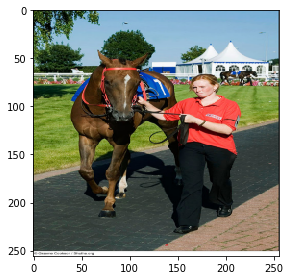

In [226]:
imshow(x[0])

#### Gettng the lab images

In [227]:
labImgs = DatasetMapper.getLABDataset(rgbImgs)

TypeError: ignored

In [228]:
for labs in labImgs.take(3):
    print(labs)

(<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>, <tf.Tensor: shape=(), dtype=stri

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 status of b'/content/sample.jpg':
0 min : 0.0
0 max : 88.86235046386719
1 min : -63.734771728515625
1 max : 87.81826782226562
2 min : -54.594398498535156
2 max : 85.92761993408203
1 status of b'/content/test3.jpg':
0 min : 0.09228897094726562
0 max : 100.0
1 min : -38.011817932128906
1 max : 74.96708679199219
2 min : -73.4144058227539
2 max : 62.30685806274414
2 status of b'/content/test4.jpg':
0 min : 20.752044677734375
0 max : 69.71858215332031
1 min : -21.16924476623535
1 max : 75.57952117919922
2 min : 11.605823516845703
2 max : 64.66645050048828


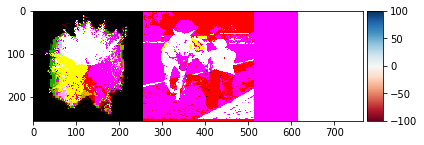

In [128]:
y = []
result = []
for i, tup in enumerate(labImgs.take(3)):
    labs = tup[0]
    fileName = tup[1]
    printNPStatus(labs.numpy(),fileName, i)
    y.append(labs.numpy())
    print('===================================================================')
y = np.asarray(y)
imshow(np.hstack(y))

(256, 768, 3)


In [ ]:
printNPStatus(imread('/content/sample.jpg'),fileName, i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


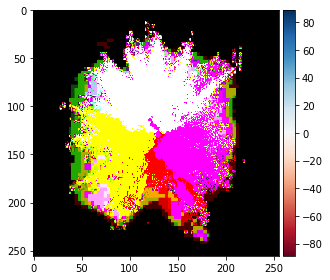

In [89]:
imshow(y[0])

In [129]:
trainData = DatasetMapper.getXYDataset(labImgs,256,256)

In [130]:
trainData

<MapDataset shapes: ((256, 256, 1), (256, 256, 2), ()), types: (tf.float32, tf.float32, tf.string)>

In [132]:
z = []
i = 0
for data in enumerate(trainData.take(3)):
    _l = data[1][0].numpy()
    _ab = data[1][1].numpy()*128
    fileName = data[1][2]
    # print(data)
    # print(data[1][1].numpy())
    printNPSplitStatus(_l, _ab, fileName, i)
    z.append((_l,_ab))
    print('===================================================================')
# z = np.asarray(z)

0 status of b'/content/test3.jpg': 0
L min : 0.09228897094726562
L max : 100.0
A min : -38.011817932128906
A max : 74.96708679199219
B min : -73.4144058227539
B max : 62.30685806274414
0 status of b'/content/test4.jpg': 0
L min : 20.752044677734375
L max : 69.71858215332031
A min : -21.16924476623535
A max : 75.57952117919922
B min : 11.605823516845703
B max : 64.66645050048828
0 status of b'/content/sample.jpg': 0
L min : 0.0
L max : 88.86235046386719
A min : -63.734771728515625
A max : 87.81826782226562
B min : -54.594398498535156
B max : 85.92761993408203


In [214]:
daf = imread('/content/test4.jpg')
print(daf)

[[[139 178 147]
  [139 178 147]
  [139 178 147]
  ...
  [ 82  40   0]
  [ 82  40   0]
  [ 82  40   0]]

 [[139 178 147]
  [139 178 147]
  [139 178 147]
  ...
  [ 82  40   0]
  [ 82  40   0]
  [ 82  40   0]]

 [[139 178 147]
  [139 178 147]
  [139 178 147]
  ...
  [ 82  40   0]
  [ 82  40   0]
  [ 82  40   0]]

 ...

 [[139 178 147]
  [139 178 147]
  [139 178 147]
  ...
  [ 82  40   0]
  [ 82  40   0]
  [ 82  40   0]]

 [[139 178 147]
  [139 178 147]
  [139 178 147]
  ...
  [ 82  40   0]
  [ 82  40   0]
  [ 82  40   0]]

 [[139 178 147]
  [139 178 147]
  [139 178 147]
  ...
  [ 82  40   0]
  [ 82  40   0]
  [ 82  40   0]]]


In [215]:
# daf = daf.astype('float32')
daf = resize(daf, output_shape=[256, 256])

In [216]:
daf

array([[[0.54509804, 0.69803922, 0.57647059],
        [0.54509804, 0.69803922, 0.57647059],
        [0.54509804, 0.69803922, 0.57647059],
        ...,
        [0.32156863, 0.15686275, 0.        ],
        [0.32156863, 0.15686275, 0.        ],
        [0.32156863, 0.15686275, 0.        ]],

       [[0.54509804, 0.69803922, 0.57647059],
        [0.54509804, 0.69803922, 0.57647059],
        [0.54509804, 0.69803922, 0.57647059],
        ...,
        [0.32156863, 0.15686275, 0.        ],
        [0.32156863, 0.15686275, 0.        ],
        [0.32156863, 0.15686275, 0.        ]],

       [[0.54509804, 0.69803922, 0.57647059],
        [0.54509804, 0.69803922, 0.57647059],
        [0.54509804, 0.69803922, 0.57647059],
        ...,
        [0.32156863, 0.15686275, 0.        ],
        [0.32156863, 0.15686275, 0.        ],
        [0.32156863, 0.15686275, 0.        ]],

       ...,

       [[0.54509804, 0.69803922, 0.57647059],
        [0.54509804, 0.69803922, 0.57647059],
        [0.54509804, 0

In [219]:
printNPStatus(daf,'test4',1)

1 status of test4: 1
0 min : 0.2273514093137255
0 max : 0.9492493872549019
1 min : 0.0
1 max : 0.6980392156862745
2 min : 0.0
2 max : 0.5764705882352941


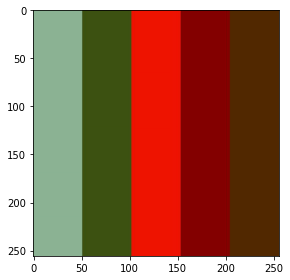

In [220]:
imshow(daf)

In [107]:
labdaf = rgb2lab(daf)

In [108]:
labdaf

array([[[ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05],
        [ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05],
        [ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05],
        ...,
        [ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05],
        [ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05],
        [ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05]],

       [[ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05],
        [ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05],
        [ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05],
        ...,
        [ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05],
        [ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05],
        [ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05]],

       [[ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05],
        [ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05],
        [ 2.74173496e-01, -1.74071274e-05,  3.29952171e-05],
        ...,
        [ 2.74173496e-01, -1.74071274e-05,

In [135]:
printNPStatus(labdaf, 'sampel,', 'lab')

lab status of sampel,:
0 min : 0.0
0 max : 96.46240964901942
1 min : -0.5162792756039014
1 max : 0.6898285967606812
2 min : -0.4283855730386043
2 max : 0.7120987021398256


In [133]:
labdaf[:,:,1:] = labdaf[:,:,1:] / 128 